# Mini-project n° 2– Conditional VAEs

In [2]:
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Chargement des données

In [3]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

# Charger le jeu de données Fashion-MNIST
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


# Création des échantillons test et train
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Fonction utilisée pour afficher les images

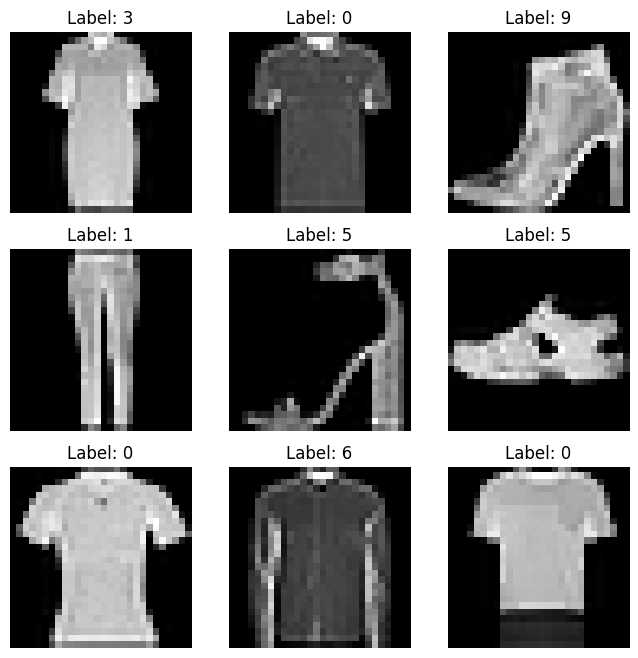

In [4]:
def plot_images(img_dataset):

    #Grille 3*3 pour permettre l'affichage de 9 images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
  
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  
        img, label = img_dataset[random_idx]  #récupération de l'image et de son label associé
        figure.add_subplot(rows, cols, i)  
        plt.title(f'Label: {label}') 
        plt.axis("off")  
        plt.imshow(img.squeeze(), cmap="gray") 
    
    plt.show()  

plot_images(train_dataset)

Fonction qui permet de transformer les données au format one-hot

In [6]:
#Récupération au format one-hot encoding des labels
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

# Définition du modele : 

On met en place ici un modèle VAE Conditionnel. C'est un modèle où l'encodage latent dépend des images d'entrée mais également des labels associés à chaque image. L'objectif de ce modèle est donc de générer des images en fonction d'une étiquette de données spécifique.

Choix de l'architecture : 

Choix des couches : couches de convolution plus adaptées pour gérer les images car les images contiennent énormément de données

Choix de la taille des couches : 

Choix des hyperparamètres : 
- batch size : 
- learning rate : 
- nombre d'epoch :
- regularization weight :


In [8]:
class ConvCVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4)  # Flatten the output of the convolutional layers

        # Concatenate the labels (one-hot encoded) with the encoder output
        x = torch.cat((x, labels), dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=1)
        z = z.to(device)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.sample(mu, logvar)
        return self.decode(z, labels), mu, logvar

Fonction de perte 

Choix de la fonction de perte : 
- les différents termes et leurs objectifs : 

In [11]:
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

Entrainement du modèle

In [12]:
import torch
import torch.optim as optim

# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 10
beta = 0.5  # Regularization factor for the KL Divergence, put to 0.5 as default

# Initialize the CVAE model and the Adam optimizer
cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10)  # Notez l'ajout de num_classes
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
# Training loop
for epoch in range(1, epochs + 1):
    cvae.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the cumulative loss for the current epoch

    # Iterate through the batches of training data
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)  # Move the input data to the GPU (if available)

        # Convert labels to one-hot encoding
        one_hot_labels = one_hot(labels, class_size=10).to(device)  # Assurez-vous que cela soit sur le bon device

        # Zero the gradients for this batch
        optimizer.zero_grad()

        # Forward pass through the model (passer les étiquettes aussi)
        recon_batch, mu, logvar = cvae(data, one_hot_labels)

        # Compute the loss for this batch
        loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]

        # Backpropagate the loss and update model parameters
        loss.backward()
        optimizer.step()

        # Accumulate the batch loss
        running_loss += loss.item()

    # Compute and print the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')


Epoch 1, Training loss: 277.8443
Epoch 2, Training loss: 255.2272
Epoch 3, Training loss: 253.5056
Epoch 4, Training loss: 252.6754
Epoch 5, Training loss: 251.8949
Epoch 6, Training loss: 251.3740
Epoch 7, Training loss: 250.9980
Epoch 8, Training loss: 250.6627
Epoch 9, Training loss: 250.3178
Epoch 10, Training loss: 250.1345


Visualisation des résultats

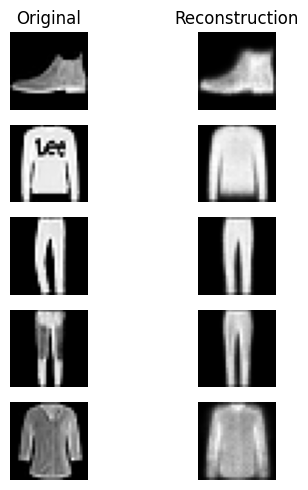

Moyenne de la MSE: 0.02117212489247322


In [13]:
def image_comparison(original_images, reconstructions, n_images=5):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(n_images, 2, figsize=(5, 5))
    #mse_loss = torch.zeros(n_images)

    for i in range(n_images):
        # Plot original images
        ax[i, 0].imshow(original_images[i], cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].set_xlabel("0")
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[i, 1].imshow(reconstructions[i], cmap='gray')
        ax[i, 1].axis('off')
        ax[i, 1].set_xlabel("1")
        ax[0, 1].set_title('Reconstruction')

        #mse_loss[i] = torch.mean((torch.tensor(reconstructions[i]) - torch.tensor(original_images[i])) ** 2)
    
    plt.tight_layout()
    plt.show()

 
    loss_moy = mse_loss.mean()

    #print(f'Moyenne de la MSE: {loss_moy.item()}')


# Select a batch of images from the test dataset
random_images, labels = next(iter(test_loader))  # Extraire les labels aussi

# Convert labels to one-hot encoding
one_hot_labels = one_hot(labels, class_size=10).to(device)  # Assurez-vous que cela soit sur le bon device

# Get the reconstructions of the selected images
recons, _, _ = cvae(random_images.to(device), one_hot_labels)  # Passer les labels ici

# Reshape the images for plotting
random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)


Génération de 5 échantillons par classe.

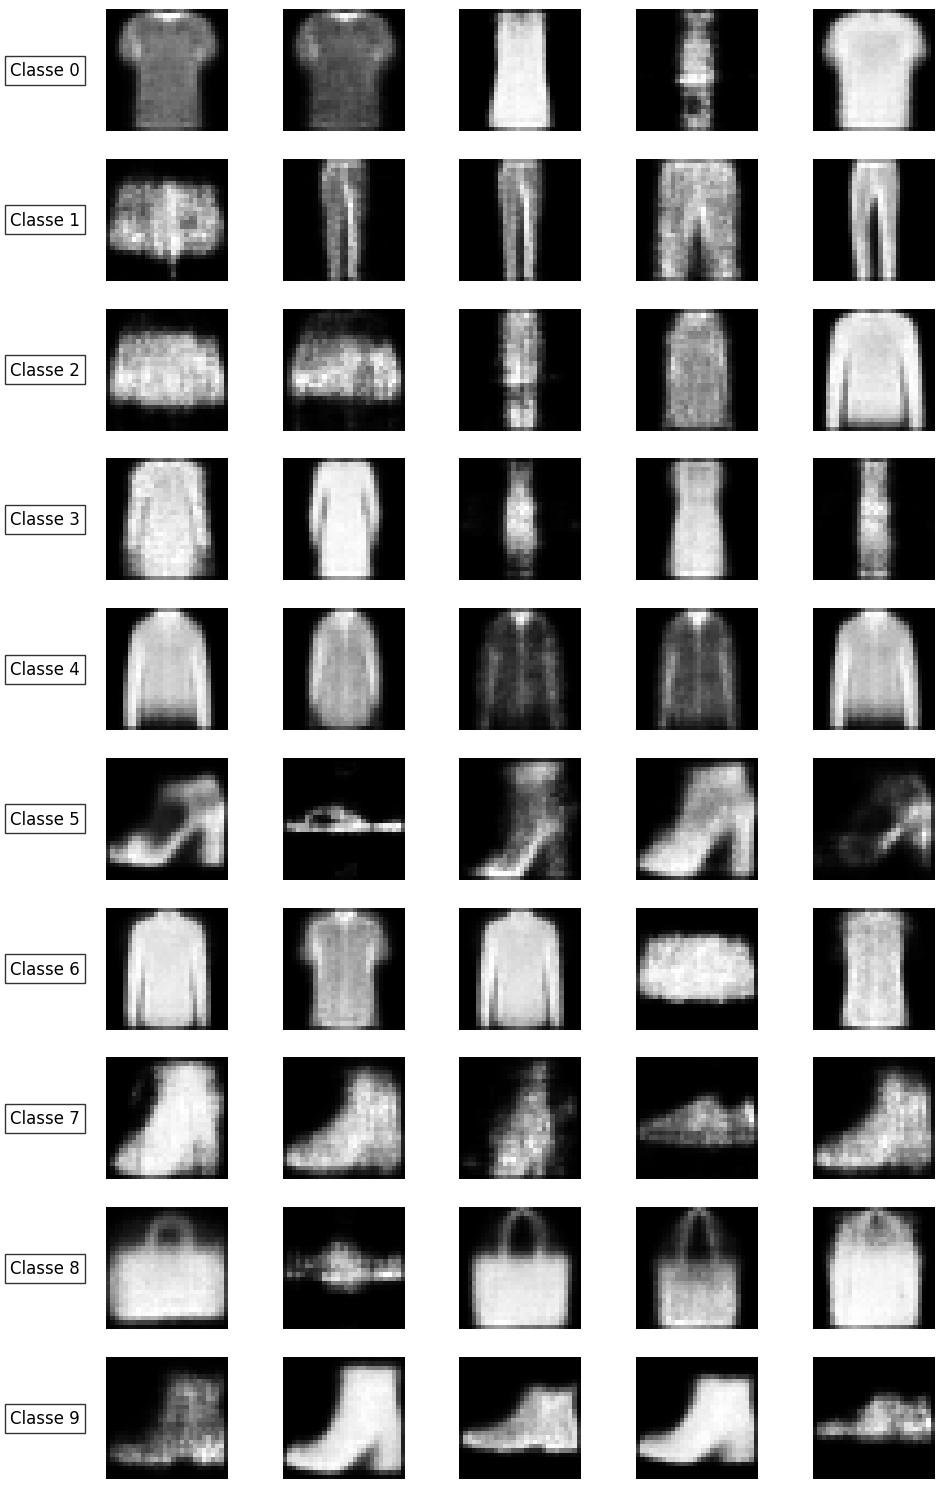

In [14]:

# Assure-toi que ton modèle est chargé et en mode évaluation
cvae.eval()

num_classes = 10  # Fashion-MNIST a 10 classes
num_samples_per_class = 5

# Fonction pour générer et afficher des échantillons pour chaque classe
def generate_samples_per_class(model, num_classes, num_samples):
    samples = []
    for class_label in range(num_classes):
        class_samples = []
        for _ in range(num_samples):
            # Créer un vecteur conditionnel pour la classe
            y = torch.tensor([class_label]).to(torch.long)
            y = torch.nn.functional.one_hot(y, num_classes).float()

            # Générer un échantillon latent
            z = torch.randn(1, model.latent_dim)  # Ajuste la taille selon ton modèle
            
            # Passer z et y dans le décodeur
            with torch.no_grad():
                generated_image = model.decode(z, y)
                
            # Ajouter l'image générée à la liste
            class_samples.append(generated_image.squeeze().cpu())
        samples.append(class_samples)
    return samples


# Générer les échantillons
samples = generate_samples_per_class(cvae, num_classes, num_samples_per_class)

# Créer une figure pour l'affichage
fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

# Afficher les échantillons regroupés par classe
for class_label in range(num_classes):
    for sample_idx in range(num_samples_per_class):
        # Afficher chaque échantillon dans sa position spécifique
        axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
        axs[class_label, sample_idx].axis("off")
    
    axs[class_label, 0].text(-0.5, 0.5, f"Classe {class_label}", 
                             rotation=0, size=12, ha="center", va="center",
                             bbox=dict(facecolor='white', alpha=0.8),
                             transform=axs[class_label, 0].transAxes)

plt.tight_layout(h_pad=2)
plt.show()

# Hyperparamètres
Maintenant que nous avons des premiers résultats, nous nous intéressons aux choix des hyperparamètres.

In [12]:
# Ensure deterministic results for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Hyperparameter grid for the search
param_grid = {
    #'batch_size': 128, fixer lors des split d'echantillons
    'latent_dim': [2, 4, 10, 20],  # Latent dimensions
    'epochs': [10],  # Number of epochs
    'beta': [1, 5, 10, 15],
    'learning_rate' : [1e-3]
}

# Randomized Search for the best hyperparameters
def optimize_hyperparameters(param_grid):
    best_params = None
    best_loss = float('inf')

    # Randomly sample from the hyperparameter grid
    for _ in range(10):  # Random search with 10 iterations
        params = {key: random.choice(value) for key, value in param_grid.items()}
        batch_size = params['batch_size']
        latent_dim = params['latent_dim']
        learning_rate = params['learning_rate']
        epochs = params['epochs']
        beta = params['beta']

        print(f"Train(10ing with params: {params}")

        model = ConvCVAE(latent_dim=latent_dim, num_classes=10)
        
        #loss = train_cvae(model, train_loader, epochs, learning_rate, beta, batch_size)
        # Initialize the CVAE model and the Adam optimizer
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(1, epochs + 1):
            model.train()  # Set the model to training mode
            running_loss = 0.0  # Initialize the cumulative loss for the current epoch

            # Iterate through the batches of training data
            for batch_idx, (data, labels) in enumerate(train_loader):
                data = data.to(device)  # Move the input data to the GPU (if available)

                # Convert labels to one-hot encoding
                one_hot_labels = one_hot(labels, class_size=10).to(device) 

                # Zero the gradients for this batch
                optimizer.zero_grad()

                # Forward pass through the model (passer les étiquettes aussi)
                recon_batch, mu, logvar = model(data, one_hot_labels)

                # Compute the loss for this batch
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                mse_loss = torch.mean((torch.tensor(reconstructions[i]) - torch.tensor(original_images[i])) ** 2)
                
                # Backpropagate the loss and update model parameters
                loss.backward()
                optimizer.step()

                # Accumulate the batch loss
                running_loss += loss.item()

            # Compute and print the average loss for this epoch
            epoch_loss = running_loss / len(train_loader.dataset)
            print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')
        loss = epoch_loss

        if loss < best_loss:
            best_loss = loss
            best_params = params

    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Training Loss: {best_loss:.4f}")


# Run the optimization
optimize_hyperparameters(param_grid)

KeyError: 'batch_size'

# Visualisation de l'espace latent

Ainsi, d'après nos observations précédentes, on décide de visualsier la représentation de l'espace latent et la génration d'échantillons correspondants avec différentes valeurs de beta,donc différents poids de la KLD dans notre fonction de perte.
Cela nous permettrait de juger quel beta nous donne la meilleur génération, même si cela restera à nuancer avec la qualité de reconstruction.


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 278.4977, BCE: 273.4826, KLD: 5.0151
Epoch 2: Average Loss: 257.7311, BCE: 252.7195, KLD: 5.0116
Epoch 3: Average Loss: 256.1114, BCE: 251.1052, KLD: 5.0062
Epoch 4: Average Loss: 255.2784, BCE: 250.2908, KLD: 4.9876
Epoch 5: Average Loss: 254.5247, BCE: 249.5518, KLD: 4.9729
Epoch 6: Average Loss: 254.0283, BCE: 249.0798, KLD: 4.9484
Epoch 7: Average Loss: 253.8268, BCE: 248.8987, KLD: 4.9281
Epoch 8: Average Loss: 253.2724, BCE: 248.3732, KLD: 4.8992
Epoch 9: Average Loss: 252.8903, BCE: 247.9999, KLD: 4.8904
Epoch 10: Average Loss: 252.6648, BCE: 247.7709, KLD: 4.8939


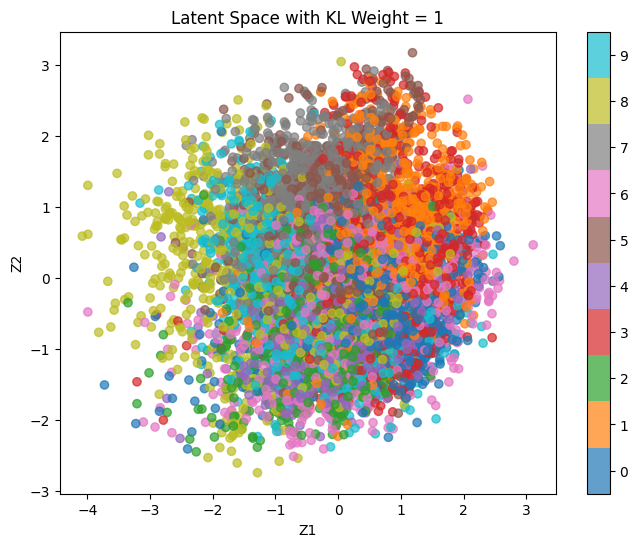

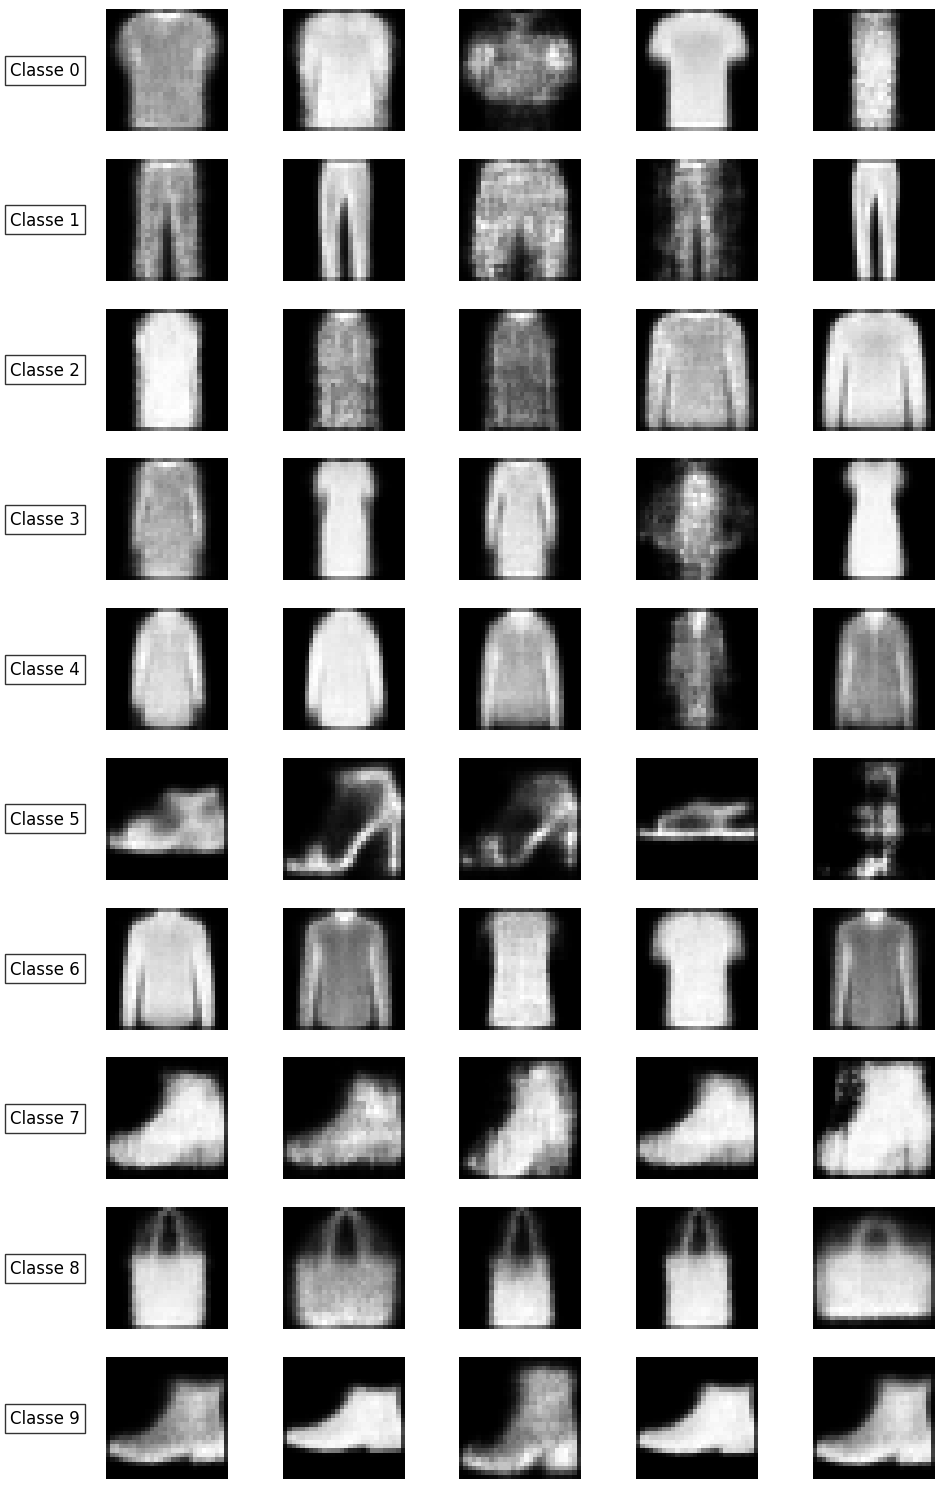


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 303.3916, BCE: 289.1636, KLD: 1.4228
Epoch 2: Average Loss: 283.8243, BCE: 267.3379, KLD: 1.6486
Epoch 3: Average Loss: 281.7948, BCE: 264.8599, KLD: 1.6935
Epoch 4: Average Loss: 280.5882, BCE: 263.4608, KLD: 1.7127
Epoch 5: Average Loss: 279.8212, BCE: 262.5880, KLD: 1.7233
Epoch 6: Average Loss: 279.3298, BCE: 261.9454, KLD: 1.7384
Epoch 7: Average Loss: 278.8698, BCE: 261.4364, KLD: 1.7433
Epoch 8: Average Loss: 278.4833, BCE: 260.9723, KLD: 1.7511
Epoch 9: Average Loss: 278.3717, BCE: 260.7605, KLD: 1.7611
Epoch 10: Average Loss: 278.1760, BCE: 260.5100, KLD: 1.7666


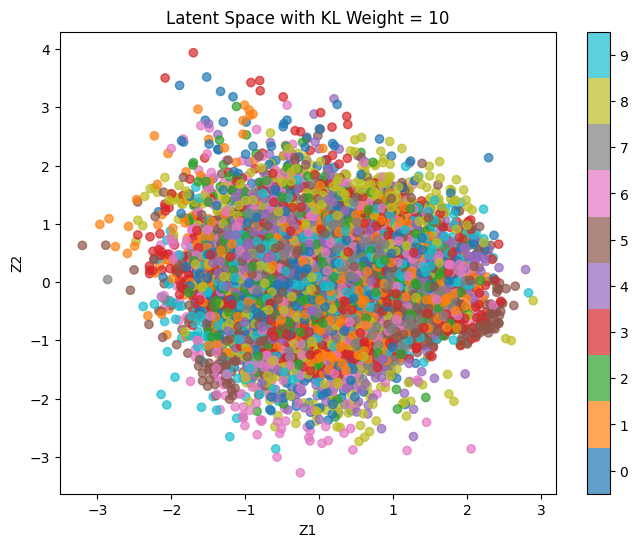

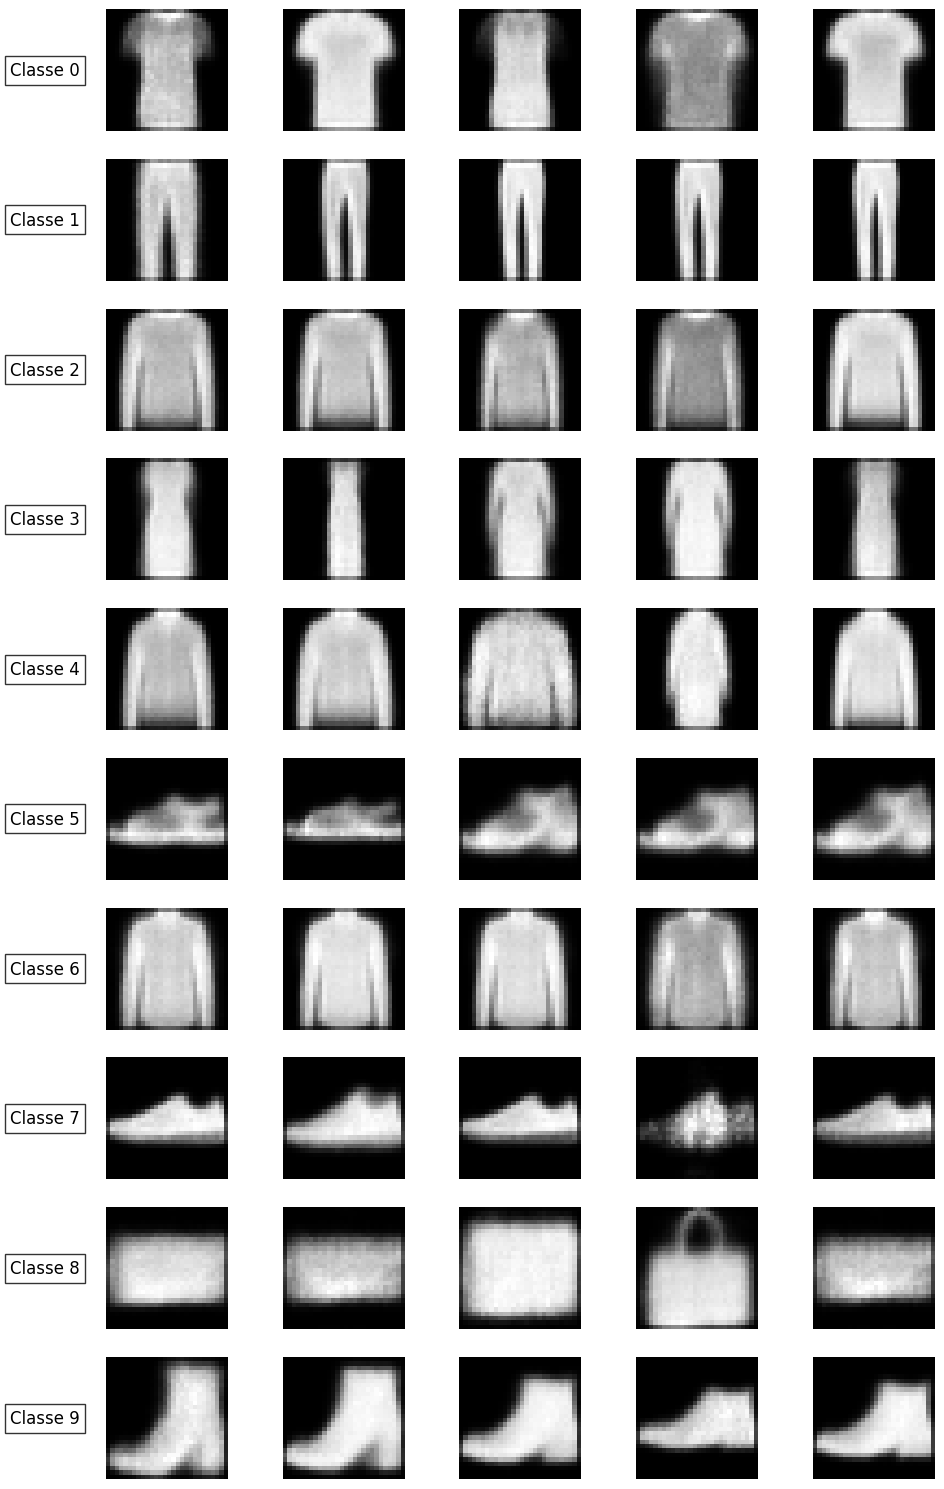


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 320.8482, BCE: 318.5394, KLD: 0.0231
Epoch 2: Average Loss: 308.0968, BCE: 307.9548, KLD: 0.0014
Epoch 3: Average Loss: 307.7990, BCE: 307.7118, KLD: 0.0009
Epoch 4: Average Loss: 307.7063, BCE: 307.6186, KLD: 0.0009
Epoch 5: Average Loss: 307.6614, BCE: 307.5642, KLD: 0.0010
Epoch 6: Average Loss: 307.5765, BCE: 307.4886, KLD: 0.0009
Epoch 7: Average Loss: 307.5723, BCE: 307.5021, KLD: 0.0007
Epoch 8: Average Loss: 307.5411, BCE: 307.4666, KLD: 0.0007
Epoch 9: Average Loss: 307.4695, BCE: 307.3851, KLD: 0.0008
Epoch 10: Average Loss: 307.4735, BCE: 307.4022, KLD: 0.0007


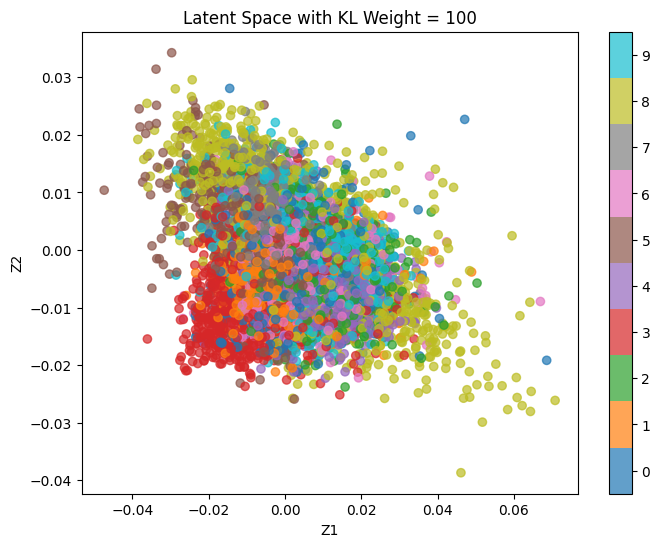

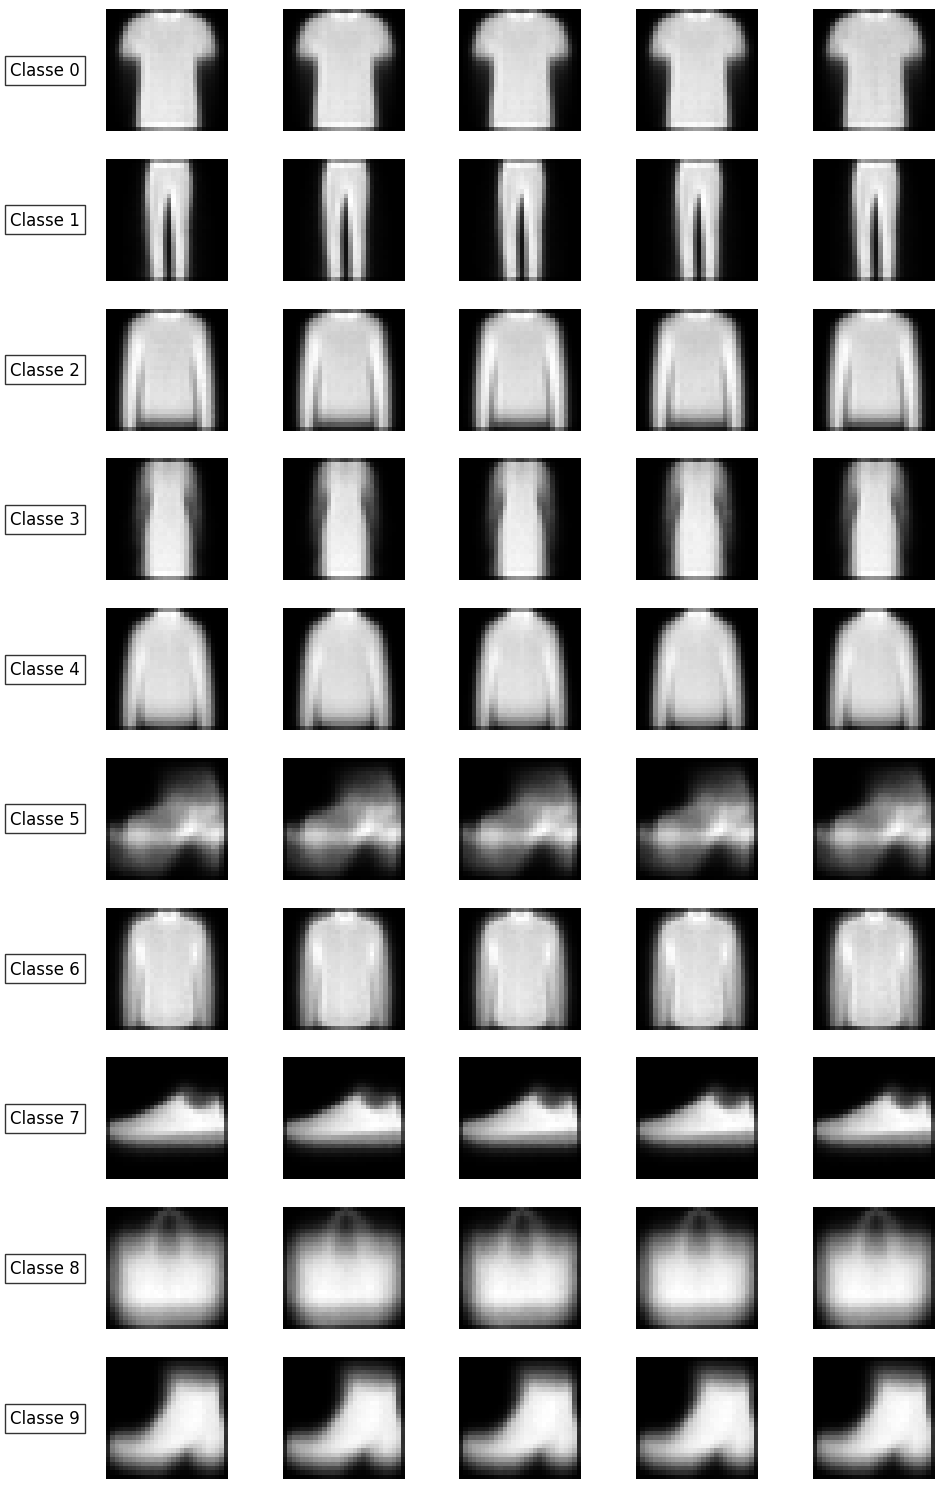

In [15]:
# Hyperparameters
latent_dims = 2
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

# Train and plot function for CVAE
def train_and_plot(kl_weight):
    model = ConvCVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            one_hot_labels = one_hot(labels, class_size=10).to(device)

            optimizer.zero_grad()

            # Forward pass through the CVAE
            x_recon, mu, logvar = model(data, one_hot_labels)

            # Compute the loss
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')

    # Plot latent space
    plot_latent_space(model, kl_weight)
    return model

# Function to plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        one_hot_labels = one_hot(labels, class_size=10).to(device)

        mu, logvar = model.encode(data, one_hot_labels)  # Encoding the data with the one-hot labels
        z = mu  # Use the mean of the latent variable for visualization
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    model = train_and_plot(kl_weight)
    # Assure-toi que ton modèle est chargé et en mode évaluation
    model.eval()

    num_classes = 10  # Fashion-MNIST a 10 classes
    num_samples_per_class = 5
    # Générer les échantillons
    samples = generate_samples_per_class(model, num_classes, num_samples_per_class)

    # Créer une figure pour l'affichage
    fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 15))

    # Afficher les échantillons regroupés par classe
    for class_label in range(num_classes):
        for sample_idx in range(num_samples_per_class):
            # Afficher chaque échantillon dans sa position spécifique
            axs[class_label, sample_idx].imshow(samples[class_label][sample_idx], cmap="gray")
            axs[class_label, sample_idx].axis("off")
        
        axs[class_label, 0].text(-0.5, 0.5, f"Classe {class_label}", 
                                rotation=0, size=12, ha="center", va="center",
                                bbox=dict(facecolor='white', alpha=0.8),
                                transform=axs[class_label, 0].transAxes)

    plt.tight_layout(h_pad=2)
    plt.show()


On voit donc que plus beta est grand, plus on est capable de distinguer à l'oeil nu les différentes catégories de vêtements. On peut voir dans le 3ème graphique, le cas beta=100, que par exemple la classe 9 est à part des autres classes, et qu'elles sont moins confondues que pour les cas. Pour véirifier cela, nous allons regénérer des échantillons en prenant beta=100. 


In [20]:
from torch.utils.data import DataLoader


In [36]:
test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
data, labels = next(iter(test_loader))
data.shape

torch.Size([10000, 1, 28, 28])

Epoch 1, Beta 1, Loss: 274.4876
Epoch 2, Beta 1, Loss: 258.5928
Epoch 3, Beta 1, Loss: 256.8093
Epoch 4, Beta 1, Loss: 255.9917
Epoch 5, Beta 1, Loss: 255.3654
Epoch 6, Beta 1, Loss: 254.7400
Epoch 7, Beta 1, Loss: 254.3690
Epoch 8, Beta 1, Loss: 253.9347
Epoch 9, Beta 1, Loss: 253.6018
Epoch 10, Beta 1, Loss: 253.1617
Epoch 1, Beta 10, Loss: 296.1294
Epoch 2, Beta 10, Loss: 283.2282
Epoch 3, Beta 10, Loss: 281.2957
Epoch 4, Beta 10, Loss: 280.2647
Epoch 5, Beta 10, Loss: 279.5482
Epoch 6, Beta 10, Loss: 279.2501
Epoch 7, Beta 10, Loss: 278.7003
Epoch 8, Beta 10, Loss: 278.4225
Epoch 9, Beta 10, Loss: 278.2404
Epoch 10, Beta 10, Loss: 277.9916
Epoch 1, Beta 100, Loss: 319.6742
Epoch 2, Beta 100, Loss: 308.1470
Epoch 3, Beta 100, Loss: 307.8403
Epoch 4, Beta 100, Loss: 307.7419
Epoch 5, Beta 100, Loss: 307.6739
Epoch 6, Beta 100, Loss: 307.5937
Epoch 7, Beta 100, Loss: 307.5747
Epoch 8, Beta 100, Loss: 307.5063
Epoch 9, Beta 100, Loss: 307.4848
Epoch 10, Beta 100, Loss: 307.5022


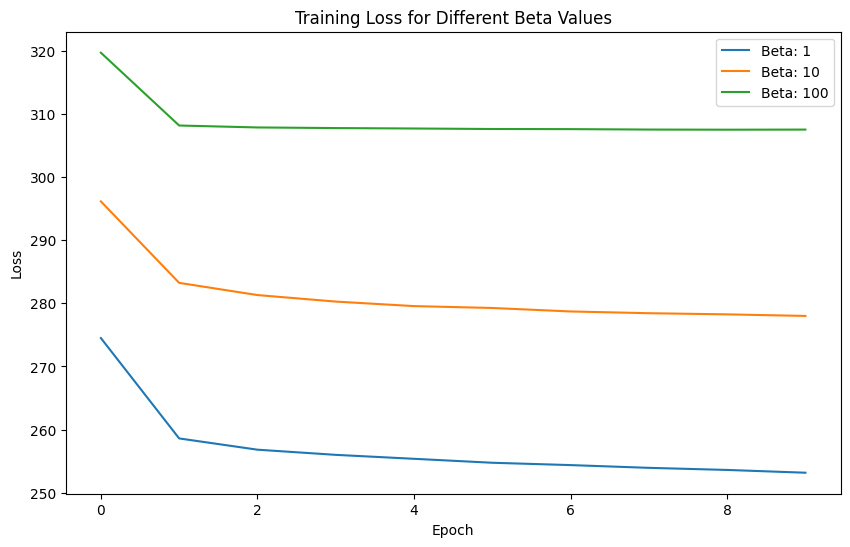

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.optim as optim

# Fonction d'entraînement avec traçage des courbes de perte
def train_with_different_betas(betas, epochs=10, latent_dim=2, learning_rate=1e-3):
    history = {}
    for beta in betas:
        cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
        optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
        
        epoch_losses = []
        for epoch in range(1, epochs + 1):
            cvae.train()
            running_loss = 0.0
            for data, labels in train_loader:
                data = data.to(device)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                optimizer.zero_grad()
                recon_batch, mu, logvar = cvae(data, one_hot_labels)
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_losses.append(epoch_loss)
            print(f'Epoch {epoch}, Beta {beta}, Loss: {epoch_loss:.4f}')
        
        history[beta] = epoch_losses

    # Plotting loss curves for each beta
    plt.figure(figsize=(10, 6))
    for beta, losses in history.items():
        plt.plot(losses, label=f'Beta: {beta}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss for Different Beta Values')
    plt.show()
    return history

# Appel de la fonction avec différentes valeurs de beta
betas = [1,10,100]
history = train_with_different_betas(betas)


On remarque dans le graphique ci-dessus que plus beta est petit plus la fonction de perte est minimiser

Pour avoir un résultat vraiment optimal, il faut non seulement minimiser la fonction de perte mais aussi il faut minimiser l'erreur de reconstruction des images. Pour évaluer cette erreur, nous avons choisi d'utiliser la MSE. 

In [18]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.optim as optim

def train_with_different_params(param_grid, batch_size=128) :
    history = {}
    mse_history = {}
    best_params = None
    best_loss = float('inf')

    # Randomly sample from the hyperparameter grid
    for _ in range(10):  # Random search with 10 iterations
        params = {key: random.choice(value) for key, value in param_grid.items()}
        latent_dim = params['latent_dim']
        learning_rate = params['learning_rate']
        epochs = params['epochs']
        beta = params['beta']

        print(f"Training with params: {params}")

        cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
        optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
        
        epoch_losses = []
        epoch_mses = []
        
        for epoch in range(1, epochs + 1):
            cvae.train()
            running_loss = 0.0
            running_mse = 0.0
            
            for data, labels in train_loader:
                data = data.to(device)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                optimizer.zero_grad()
                recon_batch, mu, logvar = cvae(data, one_hot_labels)
                
                # Compute loss and MSE
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_mse += mse
            
            # Average loss and MSE over the dataset
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_mse = running_mse / len(train_loader.dataset)
            epoch_losses.append(epoch_loss)
            epoch_mses.append(epoch_mse)
            
            print(f'Epoch {epoch}, Beta {beta}, Latent_Dim {latent_dim}, Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}')
        
        history[beta] = epoch_losses
        mse_history[beta] = epoch_mses

    # Plotting loss curves for each beta
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    for beta, losses in history.items():
        plt.plot(losses, label=f'Beta: {beta}')
    plt.xlabel('Epoch')manière
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss for Different Beta Values')

    plt.subplot(1, 2, 2)
    for beta, mses in mse_history.items():
        plt.plot(mses, label=f'Beta: {beta}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Mean Squared Error for Different Beta Values')

    plt.tight_layout()
    plt.show()
    
    return history, mse_history

Training with params: {'latent_dim': 2, 'epochs': 10, 'beta': 10, 'learning_rate': 0.001}
Epoch 1, Beta 10, Loss: 296.2148, MSE: 0.0003
Epoch 2, Beta 10, Loss: 283.2657, MSE: 0.0003
Epoch 3, Beta 10, Loss: 281.5111, MSE: 0.0003
Epoch 4, Beta 10, Loss: 280.2554, MSE: 0.0003
Epoch 5, Beta 10, Loss: 279.6829, MSE: 0.0002
Epoch 6, Beta 10, Loss: 279.1107, MSE: 0.0002
Epoch 7, Beta 10, Loss: 278.7394, MSE: 0.0002
Epoch 8, Beta 10, Loss: 278.4072, MSE: 0.0002
Epoch 9, Beta 10, Loss: 278.1348, MSE: 0.0002
Epoch 10, Beta 10, Loss: 278.0789, MSE: 0.0002
Training with params: {'latent_dim': 4, 'epochs': 10, 'beta': 1, 'learning_rate': 0.001}
Epoch 1, Beta 1, Loss: 271.5208, MSE: 0.0002
Epoch 2, Beta 1, Loss: 248.3884, MSE: 0.0002
Epoch 3, Beta 1, Loss: 246.0346, MSE: 0.0002
Epoch 4, Beta 1, Loss: 244.7798, MSE: 0.0002
Epoch 5, Beta 1, Loss: 243.8487, MSE: 0.0002
Epoch 6, Beta 1, Loss: 243.1423, MSE: 0.0002
Epoch 7, Beta 1, Loss: 242.4660, MSE: 0.0002
Epoch 8, Beta 1, Loss: 242.1561, MSE: 0.0002


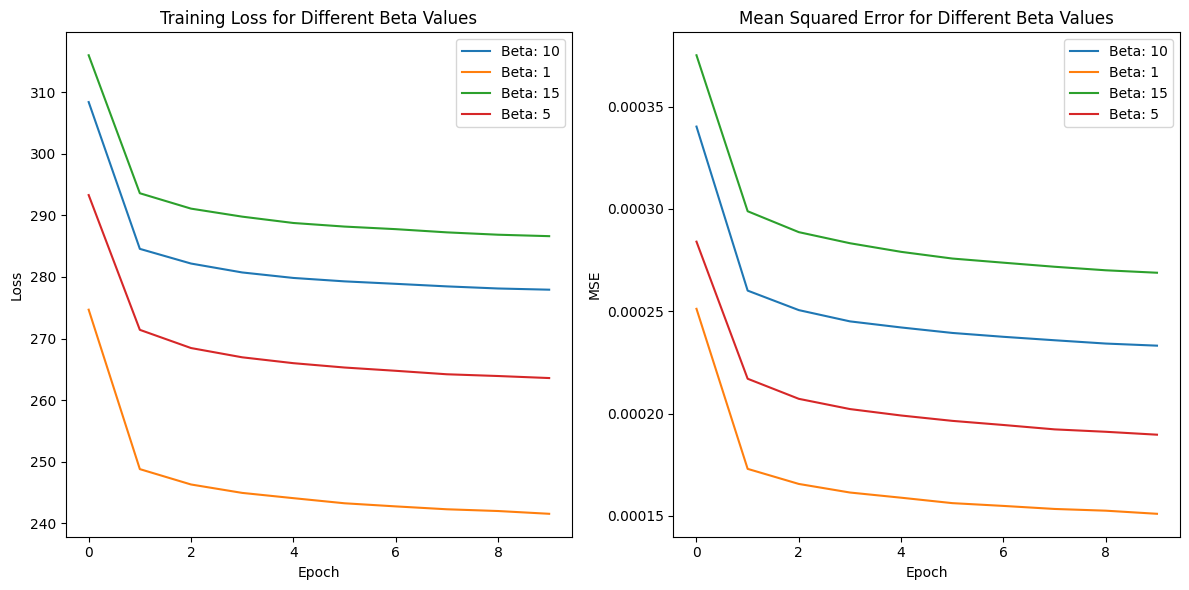

({10: [308.38261555989584,
   284.5600954752604,
   282.17745061848956,
   280.73187646484377,
   279.8402376953125,
   279.2857748697917,
   278.88603815104165,
   278.47064951171876,
   278.12962998046874,
   277.9340616536458],
  1: [274.6869464518229,
   248.81507356770834,
   246.32098834635417,
   244.95535227864585,
   244.10179248046876,
   243.2711263671875,
   242.76577054036457,
   242.29730322265624,
   242.01431302083333,
   241.56379596354168],
  15: [315.97981728515623,
   293.5864467773437,
   291.08917216796874,
   289.78945911458334,
   288.7592444335937,
   288.17665553385416,
   287.7592525716146,
   287.23811041666664,
   286.8557942057292,
   286.6212919921875],
  5: [293.2901924479167,
   271.41893570963543,
   268.46498727213543,
   266.96125830078125,
   266.00847587890627,
   265.30306321614586,
   264.7718241536458,
   264.2069408203125,
   263.9238496744792,
   263.59305143229165]},
 {10: [0.00034026546804234384,
   0.00026008128467947244,
   0.0002505480974

In [19]:
# Hyperparameter grid for the search
param_grid = {
    #'batch_size': 128, fixer lors des split d'echantillons
    'latent_dim': [2, 4, 10, 20],  # Latent dimensions
    'epochs': [10],  # Number of epochs
    'beta': [1, 5, 10, 15],
    'learning_rate' : [1e-3]
}

train_with_different_params(param_grid)

D'après les résultats obtenus, la MSE et la fonction de perte sont tout deux minimisé le plus avec un beta 

In [26]:
def train_with_different_params(param_grid, batch_size = 128 ):
    best_params = None
    best_loss = float('inf')
    best_mse = float('inf')

    # Randomly sample from the hyperparameter grid
    for _ in range(10):  # Random search with 10 iterations
        params = {key: random.choice(value) for key, value in param_grid.items()}
        latent_dim = params['latent_dim']
        learning_rate = params['learning_rate']
        epochs = params['epochs']
        beta = params['beta']

        print(f"\nTraining with params: {params}")
        
        cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
        optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
        
        for epoch in range(1, epochs + 1):
            cvae.train()
            running_loss = 0.0
            running_mse = 0.0
            
            for data, labels in train_loader:
                data = data.to(device)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                optimizer.zero_grad()
                recon_batch, mu, logvar = cvae(data, one_hot_labels)
                
                # Compute loss and MSE
                loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
                mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_mse += mse
            
            # Average loss and MSE over the dataset
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_mse = running_mse / len(train_loader.dataset)
            
            # Print epoch results
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.4f}, MSE: {epoch_mse:.4f}")
        
t
        if epoch_mse < best_mse or (epoch_mse == best_mse and epoch_loss < best_loss):
            best_params = params
            best_loss = epoch_loss
            best_mse = epoch_mse

    # Affichage de la meilleure combinaison de paramètres
    print("\nBest Parameters:")
    print(f"Params: {best_params}, Best Loss: {best_loss:.4f}, Best MSE: {best_mse:.4f}")


In [27]:
param_grid = {
    'latent_dim': [2, 4, 10, 20],  
    'epochs': [10],
    'beta': [1, 5, 10, 15],
    'learning_rate' : [1e-3]
}

train_with_different_params(param_grid)


Training with params: {'latent_dim': 20, 'epochs': 10, 'beta': 5, 'learning_rate': 0.001}
Epoch 1/10, Loss: 299.4396, MSE: 0.0003
Epoch 2/10, Loss: 272.6566, MSE: 0.0002
Epoch 3/10, Loss: 269.4962, MSE: 0.0002
Epoch 4/10, Loss: 267.8478, MSE: 0.0002
Epoch 5/10, Loss: 266.8644, MSE: 0.0002
Epoch 6/10, Loss: 265.9584, MSE: 0.0002
Epoch 7/10, Loss: 265.3504, MSE: 0.0002
Epoch 8/10, Loss: 264.9054, MSE: 0.0002
Epoch 9/10, Loss: 264.5928, MSE: 0.0002
Epoch 10/10, Loss: 264.1854, MSE: 0.0002

Training with params: {'latent_dim': 10, 'epochs': 10, 'beta': 10, 'learning_rate': 0.001}
Epoch 1/10, Loss: 302.0358, MSE: 0.0003
Epoch 2/10, Loss: 284.4406, MSE: 0.0003
Epoch 3/10, Loss: 282.0984, MSE: 0.0002
Epoch 4/10, Loss: 280.7294, MSE: 0.0002
Epoch 5/10, Loss: 280.2052, MSE: 0.0002
Epoch 6/10, Loss: 279.4630, MSE: 0.0002
Epoch 7/10, Loss: 278.9627, MSE: 0.0002
Epoch 8/10, Loss: 278.6318, MSE: 0.0002
Epoch 9/10, Loss: 278.4282, MSE: 0.0002
Epoch 10/10, Loss: 278.2929, MSE: 0.0002

Training with 

KeyboardInterrupt: 

In [ ]:
import optuna

def objective(trial):
    # Définissez les hyperparamètres à optimiser
    latent_dim = trial.suggest_categorical('latent_dim', [2, 4, 10, 20])
    beta = trial.suggest_categorical('beta', [1, 5, 10, 15])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    
    cvae = ConvCVAE(latent_dim=latent_dim, num_classes=10).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    
    # Boucle d'entraînement simplifiée
    running_loss = 0.0
    running_mse = 0.0
    for epoch in range(10):  # Fixer un nombre d'époques
        cvae.train()
        for data, labels in train_loader:
            data = data.to(device)
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, one_hot_labels)
            
            loss = loss_function(recon_batch, data, mu, logvar, beta=beta)[0]
            mse = torch.nn.functional.mse_loss(recon_batch, data, reduction='mean').item()
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_mse += mse

    # Retourne une métrique pour Optuna (minimisation)
    avg_loss = running_loss / len(train_loader.dataset)
    avg_mse = running_mse / len(train_loader.dataset)
    return avg_mse

# Optimiser avec Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Meilleurs paramètres
print("\nBest trial:")
print(study.best_trial.params)


/home/catalogn/.conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-20 12:06:26,179] A new study created in memory with name: no-name-c4716d3a-a597-44aa-9710-54afd710ec8e
/tmp/ipykernel_21296/2310167013.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
[I 2024-11-20 12:07:45,709] Trial 0 finished with value: 0.003082081624555091 and parameters: {'latent_dim': 2, 'beta': 15, 'learning_rate': 9.733792560993499e-05}. Best is trial 0 with value: 0.003082081624555091.


## 6. Interpolation between Images
The objective of this section is to visualize the difference between the space of latent representations and the (original) pixel space. In order to do so, we will perform *image interpolation*, i.e., we will take two random images $x_2$ and $x_2$ from the test set, and interpolate between them: for a given number of interpolation steps $n$, we have:
- In pixel space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by taking, for each pixel, the linear interpolation
$$\frac{n-t}{n}x_1 + \frac{t}{n}x_2.$$
- In the latent space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by first computing the linear interpolation $z_t$ between the encodings $z_1$ of $x_1$ and $z_2$ of $x_2$, and then decoding $z_t$.

In [ ]:
# TODO: Implement the interpolate_pixel_space function
# the function should take two images as input and the numer of interpolation steps
# and plot the interpolated images in a single row

def interpolate_pixel_space(x1, x2, num_steps=10):
    # Ensure the images are on the same device and have the correct shape
    x1 = x1.view(1, 1, 28, 28).to(device)
    x2 = x2.view(1, 1, 28, 28).to(device)

    # Generate interpolation factors between 0 and 1
    t_values = torch.linspace(0, 1, num_steps).to(device).view(-1, 1, 1, 1)

    # Interpolate directly in pixel space
    interpolated_images = x1 * (1 - t_values) + x2 * t_values
# Déplacer les tenseurs sur le même dispositif
tensor1 = tensor1.to(device)
tensor2 = tensor2.to(device)zation
    interpolated_images = interpolated_images.cpu().squeeze(1)  # Remove channel dimension if necessary

    # Plot the interpolated images
    fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
    for i in range(num_steps):
        ax[i].imshow(interpolated_images[i].squeeze(0), cmap='gray')
        ax[i].axis('off')
    plt.show()

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_pixel_space(x1, x2)

RuntimeError: shape '[1, 1, 28, 28]' is invalid for input of size 1

In [ ]:
# TODO: Implement the interpolate_latent_space function
# the function should take two images as input and the numer of interpolation steps
# and plot the interpolated images in a single row

def interpolate_latent_space(x1, x2, num_steps=10):
    vae.eval()
    with torch.no_grad():
        x1, x2 = x1.to(device), x2.to(device)
        mu1, logvar1 = vae.encode(x1.view(1, 1, 28, 28))
        mu2, logvar2 = vae.encode(x2.view(1, 1, 28, 28))

        z1 = vae.sample(mu1, logvar1)
        z2 = vae.sample(mu2, logvar2)

        z = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, num_steps)])
        samples = vae.decode(z).cpu()
        samples = samples.view(num_steps, 1, 28, 28)

        fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
        for i in range(num_steps):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_latent_space(x1, x2)

## 7. Visualizing the latent space
The objective of this section is to visualize the latent space and to see how it changes according to which term in the loss function we give more weight to.

# 8. Références

Explication sur les termes de la fonction de perte : https://medium.com/@mrthinger/kl-divergence-vs-cross-entropy-exploring-the-differences-and-use-cases-3f3dee58c452